In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings

In [33]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
sample_sub = pd.read_csv("input/sample_submission.csv")

In [34]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [35]:
use_features = [
    "NAME_CONTRACT_TYPE",
    "AMT_INCOME_TOTAL",
    "EXT_SOURCE_2",
    "OWN_CAR_AGE",
    "ORGANIZATION_TYPE"
]
target = train["TARGET"].values

train = train[use_features]
train["TARGET"] = target
test = test[use_features]

In [36]:
# Numerization of NAME_CONTRACT_TYPE（Label Encoding）
train["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
test["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)

train.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,OWN_CAR_AGE,ORGANIZATION_TYPE,TARGET
0,0,112500.0,0.372591,NaN,School,0
1,0,225000.0,0.449567,NaN,XNA,0
2,0,54000.0,0.569503,NaN,Postal,0
3,0,67500.0,0.105235,NaN,XNA,0
4,0,157500.0,0.202490,NaN,Business Entity Type 3,1


In [37]:
# Numerization of ORGANIZATION_TYPE (Count Encoding）
organization_ce = train["ORGANIZATION_TYPE"].value_counts()
train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(organization_ce)
test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(organization_ce)

train.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,OWN_CAR_AGE,ORGANIZATION_TYPE,TARGET
0,0,112500.0,0.372591,NaN,4991,0
1,0,225000.0,0.449567,NaN,30898,0
2,0,54000.0,0.569503,NaN,1185,0
3,0,67500.0,0.105235,NaN,30898,0
4,0,157500.0,0.202490,NaN,37943,1


In [38]:
# Complete missing values of EXT_SOURCE_2 with the average
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True) # Use average of train data to fill test data

train.isnull().sum()

NAME_CONTRACT_TYPE         0
AMT_INCOME_TOTAL           0
EXT_SOURCE_2               0
OWN_CAR_AGE           112992
ORGANIZATION_TYPE          0
TARGET                     0
dtype: int64

In [39]:
# Treat values above 60 (outliers) in OWN_CAR_AGE as missing values
train.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan

In [40]:
# Divide OWN_CAR_AGE into groups
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train["OWN_CAR_AGE"].unique()

array([nan,  0.,  2.,  1.,  3.,  4.,  5.])

In [41]:
# Apply One Hot Encoding to OWN_CAR_AGE
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

# Add the one hot encoded columns to train/test
train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

# Remove original OWN_CAR_AGE
train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

train.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,ORGANIZATION_TYPE,TARGET,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0
0,0,112500.0,0.372591,4991,0,False,False,False,False,False,False
1,0,225000.0,0.449567,30898,0,False,False,False,False,False,False
2,0,54000.0,0.569503,1185,0,False,False,False,False,False,False
3,0,67500.0,0.105235,30898,0,False,False,False,False,False,False
4,0,157500.0,0.202490,37943,1,False,False,False,False,False,False


In [42]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [43]:
# Split the data into explanatory and target variables
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values

In [44]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
X_pt = pt.fit_transform(X)
X_test_pt = pt.transform(X_test)

In [45]:
# Standardization
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X_pt)
X_test_std = sc.transform(X_test_pt)

In [46]:
# Split the original data into the training data and the validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=0)

In [47]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,

    "num_leaves": 16,          
    "max_depth": 4,              
    "min_child_samples": 40,
    "min_child_weight": 1e-3,

    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.7,

    "reg_alpha": 0.4,    
    "reg_lambda": 0.6,

    "n_estimators": 2000,
    "early_stopping_rounds": 200,
    "random_state": 42,
    "verbose": -1
}

In [48]:
# lightGBM cause seem like this is the best for the old model
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train, eval_set= [(X_valid, y_valid)])

lgbm_train_pred = lgbm.predict_proba(X_train)[:, 1]
lgbm_valid_pred = lgbm.predict_proba(X_valid)[:, 1]

print(f"Train Score: {roc_auc_score(y_train, lgbm_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgbm_valid_pred)}")

Train Score: 0.7230757797922148
Valid Score: 0.6699231083558757


/home/tuanhung/Desktop/Dev/competitionAi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tuanhung/Desktop/Dev/competitionAi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


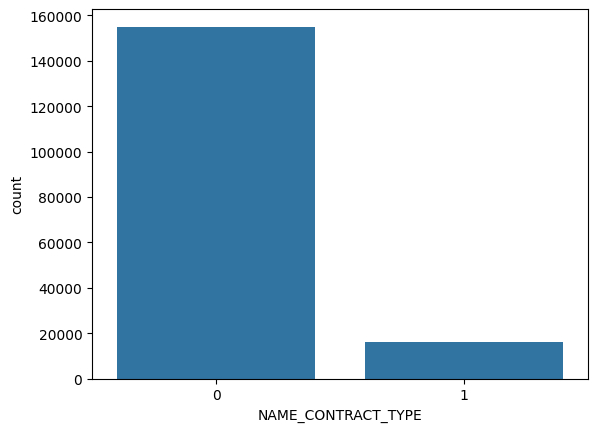

In [49]:
sns.countplot(data=train, x="NAME_CONTRACT_TYPE")
plt.show()

In [50]:
train

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,ORGANIZATION_TYPE,TARGET,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0
0,0,112500.0,0.372591,4991,0,False,False,False,False,False,False
1,0,225000.0,0.449567,30898,0,False,False,False,False,False,False
2,0,54000.0,0.569503,1185,0,False,False,False,False,False,False
3,0,67500.0,0.105235,30898,0,False,False,False,False,False,False
4,0,157500.0,0.202490,37943,1,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
171197,0,83250.0,0.404560,1338,0,False,False,True,False,False,False
171198,0,247500.0,0.608542,1833,0,True,False,False,False,False,False
171199,0,292500.0,0.664305,4991,0,False,False,False,False,False,False
171200,0,112500.0,0.627050,37943,0,True,False,False,False,False,False


### under this is the output part


In [51]:
# Make predictions for the test data
# Change model name if needed
pred = lgbm.predict_proba(X_test_std)[:, 1]

/home/tuanhung/Desktop/Dev/competitionAi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [52]:
# Put the prediction into the format of submission
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.036321
1,171203,0.099198
2,171204,0.130686
3,171205,0.056682
4,171206,0.106545
...,...,...
61495,232697,0.238151
61496,232698,0.053914
61497,232699,0.096260
61498,232700,0.141502


In [53]:
# Create the "output" directory if it doesn't exist
output_dir = Path.cwd() / "output"
os.makedirs(output_dir, exist_ok=True)

# Specify the new output file path
output_file = output_dir / "submission.csv"

# Save the CSV file to the "output" directory
sample_sub.to_csv(output_file, index=False)